# Setup and Importing Weekly Price Data 

Our first step is to set up our environment and import Fanduel price data for the slate of games in question into a DataFrame.

In [2]:
#Importing weekly price data
import pandas as pd 
%matplotlib notebook
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import linear_model

df = pd.read_csv('FanDuel-NFL-2020-11-22-51732-players-list.csv')
df.head()

,Id,Position,First Name,Nickname,Last Name,FPPG,Played,Salary,Game,Team,Opponent,Injury Indicator,Injury Details,Tier,Unnamed: 14,Unnamed: 15
0,51732-54140,RB,Dalvin,Dalvin Cook,Cook,25.787500,8,10500,DAL@MIN,MIN,DAL,NaN,NaN,NaN,NaN,NaN
1,51732-55050,RB,Christian,Christian McCaffrey,McCaffrey,16.380000,5,10000,DET@CAR,CAR,DET,NaN,Shoulder - ac joint,NaN,NaN,NaN
2,51732-42104,RB,Alvin,Alvin Kamara,Kamara,23.655555,9,9700,ATL@NO,NO,ATL,NaN,NaN,NaN,NaN,NaN
3,51732-45889,WR,Davante,Davante Adams,Adams,22.371429,7,9500,GB@IND,GB,IND,NaN,NaN,NaN,NaN,NaN
4,51732-6894,QB,Aaron,Aaron Rodgers,Rodgers,23.835556,9,9000,GB@IND,GB,IND,NaN,NaN,NaN,NaN,NaN


# Data Cleaning

We need our data to be rid of unnecessary values. Let's remove:
- Players designated as out
- Players averaging 0 FPPG
    - These are our edge cases that additional research will need to be done on (e.g. AJ Green)
- Minimum salary players (for now)
    - QB 6000
    - RB 4500
    - WR 4500
    - TE 4000


In [3]:
#Data Cleaning
df = df[(df['Injury Indicator'] != 'O') & (df['Injury Indicator'] != 'IR')]
df = df[df.FPPG > 0]
df = df[((df.Position == 'QB') & (df.Salary > 6000)) | ((df.Position == 'RB') & (df.Salary > 4500)) | ((df.Position == 'WR') & (df.Salary > 4500)) | ((df.Position == 'TE') & (df.Salary > 4000)) | (df.Position == 'D')]

# First Visualizations

Let's start by visualizing all players in a scatter plot: FPPG vs Salary.

Preliminary Observations:
 - There are a lot of TEs at the 4500 mark, presumably backups who get enough playing time to warrant a greater than minimum salary.
 - Above 5000 we seem to have a pretty linear relationship between fantasy production and salary. Let's look at this relationship by position.
 - D/ST salaries don't seem to be correlated to prior fantasy production. This is likely because D/ST scoring is highly correlated to strength of opponent offense.

<IPython.core.display.Javascript object>


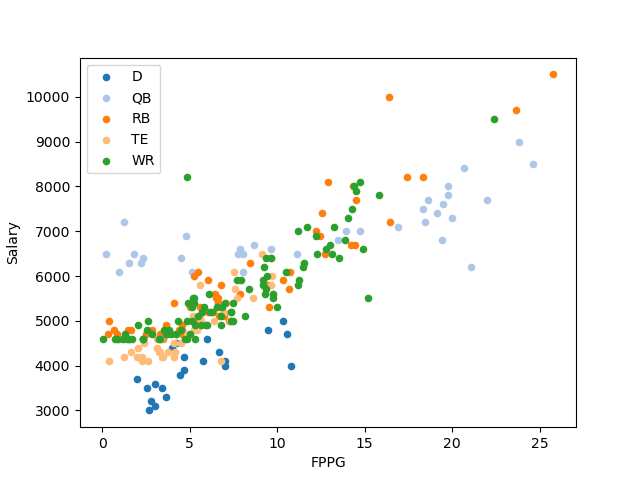

In [4]:
#Mapping positions to colors to visualize pricing
fig, ax = plt.subplots()
groups = df.groupby('Position')
colors = [(31,119,180),(174,199,232),(255,127,14),(255,187,120),(44,160,44)]

# Rescale to values between 0 and 1 
for i in range(len(colors)):  
    r, g, b = colors[i]  
    colors[i] = (r / 255., g / 255., b / 255.)

for i, (nickname, group) in enumerate(groups):
    group.plot(kind='scatter', x='FPPG', y='Salary', label=nickname,color=colors[i],ax=ax)

<IPython.core.display.Javascript object>


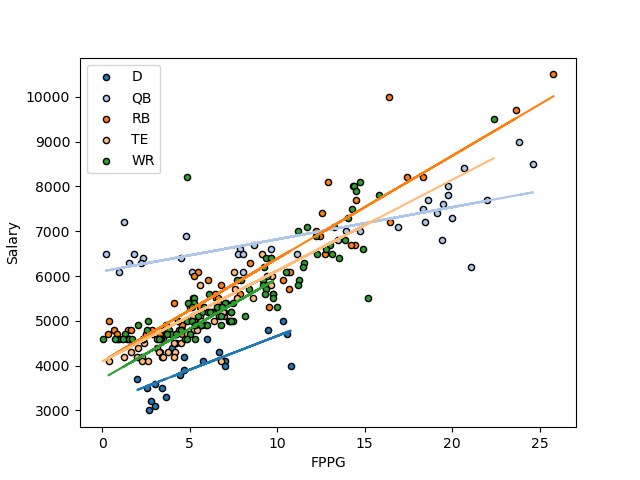

In [5]:
#Mapping positions to colors to visualize pricing
QB = df[(df['Position'] == 'QB')]
RB = df[(df['Position'] == 'RB')]
WR =  df[(df['Position'] == 'WR')]
TE = df[(df['Position'] == 'TE')]
D = df[(df['Position'] == 'D')]

lr = linear_model.LinearRegression()
Y1 = QB['Salary'].values.reshape(-1,1)
X1 = QB['FPPG'].values.reshape(-1,1)
lr.fit(X1, Y1)
Y_pred1 = lr.predict(X1)

Y2 = RB['Salary'].values.reshape(-1,1)
X2 = RB['FPPG'].values.reshape(-1,1)
lr.fit(X2, Y2)
Y_pred2 = lr.predict(X2)

Y3 = WR['Salary'].values.reshape(-1,1)
X3 = WR['FPPG'].values.reshape(-1,1)
lr.fit(X3, Y3)
Y_pred3 = lr.predict(X3)

Y4 = TE['Salary'].values.reshape(-1,1)
X4 = TE['FPPG'].values.reshape(-1,1)
lr.fit(X4, Y4)
Y_pred4 = lr.predict(X4)

Y5 = D['Salary'].values.reshape(-1,1)
X5 = D['FPPG'].values.reshape(-1,1)
lr.fit(X5, Y5)
Y_pred5 = lr.predict(X5)




fig, ax = plt.subplots()
groups = df.groupby('Position')
colors = [(31,119,180),(174,199,232),(255,127,14),(255,187,120),(44,160,44)]
# Rescale to values between 0 and 1 
for i in range(len(colors)):  
    r, g, b = colors[i]  
    colors[i] = (r / 255., g / 255., b / 255.)

for i, (nickname, group) in enumerate(groups):
    group.plot(kind='scatter', x='FPPG', y='Salary', label=nickname,color=colors[i],ax=ax,edgecolor='k')
plt.plot(X1,Y_pred1, color=colors[1])
plt.plot(X2,Y_pred2, color=colors[2])
plt.plot(X3,Y_pred3, color=colors[3])
plt.plot(X4,Y_pred4, color=colors[4])
plt.plot(X5,Y_pred5, color=colors[0])


plt.show()

# Generating Lineups
Our next step is to generate some optimal or near-optimal lineups based on available data. We could probably iterate through all possible combinations, but for now let's use some popular metaheuristics. DFS lineups are a modified version of the knapsack problem, a classic problem in combinatorial optimization. DFS lineups add the constraints of positional limitations.

In [10]:
class Player:
    def __init__(self,pos,fname,lname,fppg,played,salary,game,team,opponent):
        self.pos = pos
        self.fname = fname
        self.lname = lname
        self.fppg = float(fppg)
        self.played = int(played)
        self.salary = int(salary)
        self.game = game
        self.team = team
        self.opponent = opponent
        self.rawvalue = float(self.salary)/self.fppg

    def __str__(self):
        return self.fname + " " + self.lname + " has a rawvalue of " + str(self.rawvalue) + " and a cost of " + str(self.salary)

    def isHome(self):
        teams = self.game.split("@")
        if teams[1] == self.team:
            return True
        return False


In [16]:
class Population:
    def __init__(self,lineups,fppg):
        self.lineups = lineups
        self.fppg = [totalValue(lineup) for lineup in self.lineups]
    
    def totalValue(players, maxWeight=60000):
        print(players)
        qb = len(players[players.Position == "QB"])
        rb = len(players[players.Position == "RB"])
        wr = len(players[players.Position == "WR"])
        te = len(players[players.Position == "TE"])
        dst = len(players[players.Position == "D"])
        if qb == 1 and dst == 1 and rb >= 2 and wr >=3 and te >= 1:
            return sum(players['FPPG'])if sum(players['Salary']) < maxWeight else 0
        return 0

In [18]:
#Let's use smart initial sampling: start with 1 QB, 1 TE, 1 DST
for i in range(30):
    pop = df[df.Position == "QB"]
# Population = [df.sample(n=9) for i in range(30)]
print(Population)

[              Id Position First Name        Nickname  Last Name       FPPG  \
152  51732-86631       WR     CeeDee     CeeDee Lamb       Lamb  11.200000   
143  51732-45439       WR      Corey     Corey Davis      Davis  11.228571   
19   51732-71845       RB      Miles   Miles Sanders    Sanders  14.500000   
283  51732-86472       WR       John  John Hightower  Hightower   3.300000   
279  51732-60705       WR      Tyron   Tyron Johnson    Johnson   4.750000   
62   51732-41827       QB       P.J.     P.J. Walker     Walker   0.200000   
66   51732-73111       WR      Chase  Chase Claypool   Claypool  13.522222   
50   51732-63589       QB        Sam     Sam Darnold    Darnold   9.657143   
248  51732-55366       RB     Qadree  Qadree Ollison    Ollison   0.300000   

     Played  Salary     Game Team Opponent Injury Indicator  \
152       9    5800  DAL@MIN  DAL      MIN              NaN   
143       7    5900  TEN@BAL  TEN      BAL              NaN   
19        6    7700  PHI@CLE 

In [ ]:
def selection(pop_after_fit,n_parents):
    population_nextgen = []
    for i in range(n_parents):
        population_nextgen.append(pop_after_fit[i])
    return population_nextgen

def crossover(pop_after_sel):
    population_nextgen=pop_after_sel
    for i in range(len(pop_after_sel)):
        child=pop_after_sel[i]
        child[3:7]=pop_after_sel[(i+1)%len(pop_after_sel)][3:7]
        population_nextgen.append(child)
    return population_nextgen

def mutation(pop_after_cross,mutation_rate):
    population_nextgen = []
    for i in range(0,len(pop_after_cross)):
        chromosome = pop_after_cross[i]
        for j in range(len(chromosome)):
            if random.random() < mutation_rate:
                chromosome[j]= not chromosome[j]
        population_nextgen.append(chromosome)
    #print(population_nextgen)
    return population_nextgen

def generations(size,n_feat,n_parents,mutation_rate,n_gen,X_train,
                                   X_test, y_train, y_test):
    best_chromo= []
    best_score= []
    population_nextgen=initilization_of_population(size,n_feat)
    for i in range(n_gen):
        scores, pop_after_fit = fitness_score(population_nextgen)
        print(scores[:2])
        pop_after_sel = selection(pop_after_fit,n_parents)
        pop_after_cross = crossover(pop_after_sel)
        population_nextgen = mutation(pop_after_cross,mutation_rate)
        best_chromo.append(pop_after_fit[0])
        best_score.append(scores[0])
    return best_chromo,best_score

def geneticAlgorithm(previous, total):
    #select top n from previous generation
    previous.sort()
    #crossover randomly selected pairs from top n
    #mutate random n in generation
    
def selection

# Scoring System Overview

<img src='Fanduel Scoring.png'>

 - Half PPR
 - Decimal Scoring (devalues TDs slightly)
 - INTs are only -1
 - Return TDs count for player and DST